 <center><H1>US 2016 Presidential Election: Twitter Trends and Sentiment Analysis</H1></center>

                     
   <BR>

<div class="image123">
    <div class="imgContainer">
        <img src="img/clinton-vs-trump.jpg" height="400" width="800"/>
    </div>
   
</div>

## System Architecture

                     
   <BR>

<div class="image123">
    <div class="imgContainer">
        <img src="img/architecture.png" height="800" width="1000"/>
    </div>
   
</div>



## Process  Flow
<div class="image123">
    <div class="imgContainer">
        <img src="img/Process Flow.png" height="800" width="1000"/>
    </div>
   
</div>

## Technologies Used

<ul>
  <li>Python: Programming Language</li>
  <li>Jupyter Notebook</li>
  <li>Tweepy: Python library for Twitter streamming</li>
  <li>Mongo DB with PyMongo Library: No SQL DB for storing tweets</li>
  <li>IBM Alchemy API: for sentiment analysis</li>
  <li>Node.js: Visualization of topics modelling and hashtags trending</li>
  <li>Leaflet.js and Open Street map: Visualozation of Twitter Sentiments</li>
  <li>Python Word Cloud Library</li>
</ul>




## Twitter Data Extraction:  using Tweepy
#### Below code is to show how Tweepy API is used to get the Twitter data and store into Mongo DB.
### Please run batch program TwitterStream/twitter_stream_download_geo.py in a terminal to capture location specific tweets with filter for candidates per instructions provided in the readme.

In [ ]:
##########################################################################################################
# This is a batch program. Please run this program on terminal as - "twitter_stream_download_geo.py" 
# from the folder 'TwitterStream'.
######## python twitter_stream_download_geo.py -q trump -l CA  ###############
######## python twitter_stream_download_geo.py -q trump -l TX  ###############
######## python twitter_stream_download_geo.py -q hillary -l CA  ###############
######## python twitter_stream_download_geo.py -q hillary -l TX  ###############
# The batch program expects two command line arguments: -q for twitter query and -l for location (State abbreviation)
# The first run with the parameters : -q trump -l CA, will produce the list of tweets for the query "trump" in the state "California" 
# and write the tweets to file jason/trump_CA.json and store the same to Mongo DB collection "trump_CA"

# Before the batch program is run please configure following:
# Tweepy and PyMongo modules are installed
# A running MongoDB daemon (see readme.txt)
# config.py with Twitter Auth configuration
# Check presence of directory 'json' at the same level as the folder 'TwitterStream'
##########################################################################################################

import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import time
import argparse
import string
import config
import json
import pymongo


def get_parser():
    """Get parser for command line arguments."""
    parser = argparse.ArgumentParser(description="Twitter Downloader")
    parser.add_argument("-q",
                        "--query",
                        dest="query",
                        help="Query/Filter",
                        default='-')
    parser.add_argument("-l",
                        "--location",
                        dest="location",
                        help="Location/Filter")
    
    return parser


class MyListener(StreamListener):
    """StreamListener for streaming Twitter data."""

    def __init__(self, location, query):
        
        fname = query + '_' + location
        query_fname = format_filename(fname)
        data_dir ='json'
        self.fname = fname
        self.outfile = "../%s/stream_%s.json" % (data_dir, query_fname)
        open("../%s/stream_%s.json" % (data_dir, query_fname), 'w').close()
        mongo_client = pymongo.MongoClient()
        db = mongo_client.twitter_db
        #collection = db[fname]
        if fname in db.collection_names():
            if ( db[fname].count() != 0 ) :
                #print 'collection already exists'
                db[fname].delete_many({})

    

    def on_data(self, data):
        try:
            mongo_client = pymongo.MongoClient()
            db = mongo_client.twitter_db
            collection = db[self.fname]
            tweet = json.loads(data)
            collection.insert(tweet)
            with open(self.outfile, 'a') as f:
                f.write(data)
                print(data)
                return True
        except BaseException as e:
            print("Error on_data: %s" % str(e))
            time.sleep(5)
        return True

    def on_error(self, status):
        print(status)
        return True


def format_filename(fname):
    """Convert file name into a safe string.

    Arguments:
        fname -- the file name to convert
    Return:
        String -- converted file name
    """
    return ''.join(convert_valid(one_char) for one_char in fname)


def convert_valid(one_char):
    """Convert a character into '_' if invalid.

    Arguments:
        one_char -- the char to convert
    Return:
        Character -- converted char
    """
    valid_chars = "-_.%s%s" % (string.ascii_letters, string.digits)
    if one_char in valid_chars:
        return one_char
    else:
        return '_'

@classmethod
def parse(cls, api, raw):
    status = cls.first_parse(api, raw)
    setattr(status, 'json', json.dumps(raw))
    return status

if __name__ == '__main__':
    parser = get_parser()
    args = parser.parse_args()
    auth = OAuthHandler(config.consumer_key, config.consumer_secret)
    auth.set_access_token(config.access_token, config.access_secret)
    api = tweepy.API(auth)
    twitter_stream = Stream(auth, MyListener(args.location, args.query.replace (" ", "_")))
    if (args.location == 'CA'):
        twitter_stream.filter( track = [args.query], locations = [-124.63,32.44,-113.47,42.2] )
    elif (args.location == 'TX'):
        twitter_stream.filter( track = [args.query], locations = [-107.31,25.68,-93.25,36.7] )
    else:
        raise ValueError("Please pass either CA or TX as location argument: -l.")

    #texas = [-107.31,25.68,-93.25,36.7]
    #california = [-124.63,32.44,-113.47,42.2]


##  Data Storage :  Mongo DB and JSON

###  Mongo DB: provide document based database, similar to JSON, perfectly suited for nested structure of tweets. 

In [1]:
##########################################################################################################
# To check collections 
##########################################################################################################
import pymongo
mongo_client = pymongo.MongoClient()
db = mongo_client.twitter_db
for collection in db.collection_names():
    print("Collection name: %s and number of tweets stored: %s  " % (collection, db[collection].count()))

#To delete all the recordes from a collection
#db[fname].delete_many({})
#print db[fname].count()

# To drop all the collections from Mongo DB.
#for collection in db.collection_names():
#    db.drop_collection(collection)

##To get number of tweets from a JSON file in a terminal
#wc -l Trump_TX.json

Collection name: sentiment_trump_TX and number of tweets stored: 10  
Collection name: hillary_TX and number of tweets stored: 2095  
Collection name: sentiment_trump_CA and number of tweets stored: 241  
Collection name: hillary_CA and number of tweets stored: 1990  
Collection name: trump_TX and number of tweets stored: 9  
Collection name: trump_CA and number of tweets stored: 26209  


##  Pre-processing Tweets: Extract, Parse and Transform Tweets

In [2]:
#Extract, Parse and transform Tweets for further analysis
import re
import json
from unicodedata import normalize

#For emoticons
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
        [\(\[] #SadMouths
        [pP] #Tongue
    )"""


#Get HTML tags, @-mentions, hash tags, URLs, numbers, words with - and '
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]



tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
#Get emoji on both UCS-4 and UCS-2 build
try:
    # Wide UCS-4 build
    myre = re.compile(u'['u'\U0001F300-\U0001F64F' u'\U0001F680-\U0001F6FF' u'\u2600-\u26FF\u2700-\u27BF]+', re.UNICODE)
except re.error:
    # Narrow UCS-2 build
    myre = re.compile(u'('u'\ud83c[\udf00-\udfff]|' u'\ud83d[\udc00-\ude4f\ude80-\udeff]|' u'[\u2600-\u26FF\u2700-\u27BF])+', re.UNICODE)
    
    
def tokenize(s):
    s = normalize('NFKD', s).encode('ascii','ignore')
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens


## Trending I : Topic Modeling (most frequent terms and hashtags)

In [3]:
# Please change the file name in the variable below and point to the JSON file that you want to run.
# fname = './json/Trump_sample.json'


import operator 
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams 
import string
 
#fname = './json/Trump_sample.json'
#fname = './json/trump_TX.json'
fname = './json/trump_CA.json'
#fname = './json/hillary_CA.json'
#fname = './json/hillary_TX.json'

punctuation = list(string.punctuation)
word_list = open("./stopwords/stopwords.txt", "r")
additonalstopword =['rt', 'via', 'Did', 'Is', 'Well',  ':', '!', 'RT', 'The', 'I' ,'https','http', 'Who', 'amp', 'Not', 'For', 'A' , 'like', 'get', 'it\'s', 'don\'t', 'see', 'know', 'new' , 'say', 'i\'m', 'would', 'us', 'back', 'he\'s', 'back', 'want']

wordcloudtext=''

for line in word_list:
    additonalstopword.append(line.rstrip('\n'))
    additonalstopword.append(line.rstrip('\n') + '\'')
stop = stopwords.words('english') + punctuation + additonalstopword

with open(fname, 'r') as f:
    # python dict subclass for counting hashable objects
    count_terms = Counter()
    count_hashtags = Counter()
    
    for line in f:
        tweet = json.loads(line)
        try:         
            hash_tags = [term for term in preprocess(tweet['text']) if term.startswith('#')]
            terms_only = [term for term in preprocess(tweet['text']) if term not in stop and not term.startswith(('#', '@') )] 
            wordcloudtext+=str(terms_only)            
        except KeyError:
            continue
        
        count_hashtags.update(hash_tags)
        count_terms.update(terms_only)
        
    print("\n\n")
    print("\n\nThe 25 most frequent terms: \n")
    print("\n")
    print(count_terms.most_common(25))
    print("\n\nThe 25 most frequent hashtags: ")
    print("\n")
    print(count_hashtags.most_common(25))
    print("\n")






The 25 most frequent terms: 



[('trump', 14902), ('campaign', 3181), ('donald', 2956), ("trump's", 2038), ('breitbart', 1210), ('hillary', 1184), ('clinton', 1049), ('bannon', 819), ('vote', 758), ('media', 709), ('christie', 646), ('speech', 644), ('black', 602), ('tax', 588), ('trumps', 585), ('news', 550), ('time', 522), ('30', 516), ('office', 489), ('election', 485), ('president', 478), ('gop', 467), ('debt', 461), ('day', 459), ('https://t.co/...', 454)]


The 25 most frequent hashtags: 


[('#trump', 1293), ('#maga', 424), ('#job', 283), ('#trumppence16', 255), ('#hiring', 249), ('#imwithyou', 225), ('#nevertrump', 172), ('#trumptrain', 168), ('#tcot', 165), ('#hillary', 155), ('#trump2016', 149), ('#careerarc', 147), ('#imwithher', 139), ('#', 113), ('#clinton', 104), ('#neverhillary', 94), ('#jobs', 92), ('#gop', 91), ('#makeamericagreatagain', 82), ('#blacklivesmatter', 72), ('#wednesdaywisdom', 64), ('#hillaryclinton', 63), ('#news', 58), ('#p2', 58), ("#trump's", 55)

### Visualization - most frequent terms using Node.js

In [4]:
#Run the cell and then open html file “freq_terms_chart.html” inside the  folder “html”
#The html file can also be server through python web server.
#To do this run  simple Python web server to serve the html page.
#python -m SimpleHTTPServer 8888 # Python 2
import vincent
word_most_freq = count_terms.most_common(20)
print("\n")
print("\n\nThe 20 most frequent terms: \n")
print word_most_freq
print("\n")
labels, freq = zip(*word_most_freq)
data = {'data': freq, 'x': labels}
bar = vincent.Bar(data, iter_idx='x')
bar.to_json('./html/term_freq.json')







The 20 most frequent terms: 

[('trump', 14902), ('campaign', 3181), ('donald', 2956), ("trump's", 2038), ('breitbart', 1210), ('hillary', 1184), ('clinton', 1049), ('bannon', 819), ('vote', 758), ('media', 709), ('christie', 646), ('speech', 644), ('black', 602), ('tax', 588), ('trumps', 585), ('news', 550), ('time', 522), ('30', 516), ('office', 489), ('election', 485)]




## Trending II : Word Cloud

/Users/Home/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


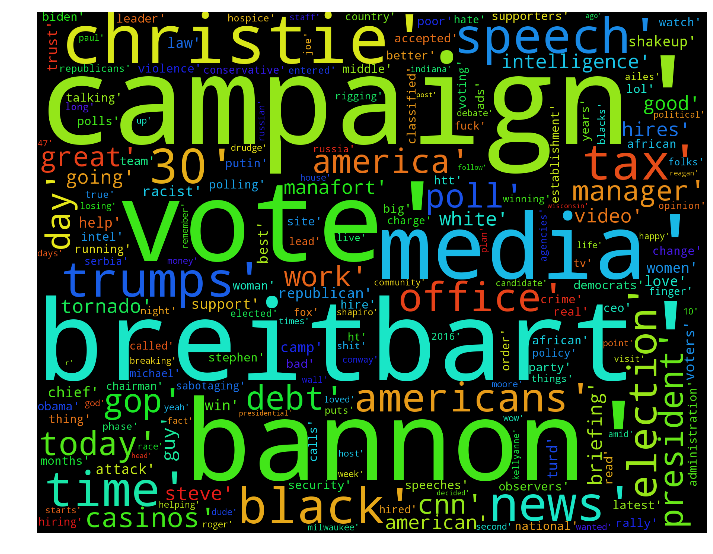

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
plt.rcParams['figure.figsize'] = (12, 12)

stopwords_new = STOPWORDS.copy()
stopwords_new.add("https")
stopwords_new.add("co")
stopwords_new.add("donald\'")
stopwords_new.add("trump\'")
stopwords_new.add("hillary\'")
stopwords_new.add("clinton\'")
stopwords_new.add("trump\'s")
stopwords_new.add("xsabdtsl3e\'")
stopwords_new.add("\'")


wordcloud = WordCloud(
                      stopwords=stopwords_new,
                      background_color='black',
                      width=1800,
                      height=1400
                      ).generate(wordcloudtext)

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./wordcloud/twitter_wordcloud_classic.png', dpi=300)

plt.show()

/Users/Home/anaconda/lib/python2.7/site-packages/wordcloud/wordcloud.py:286: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0 and"


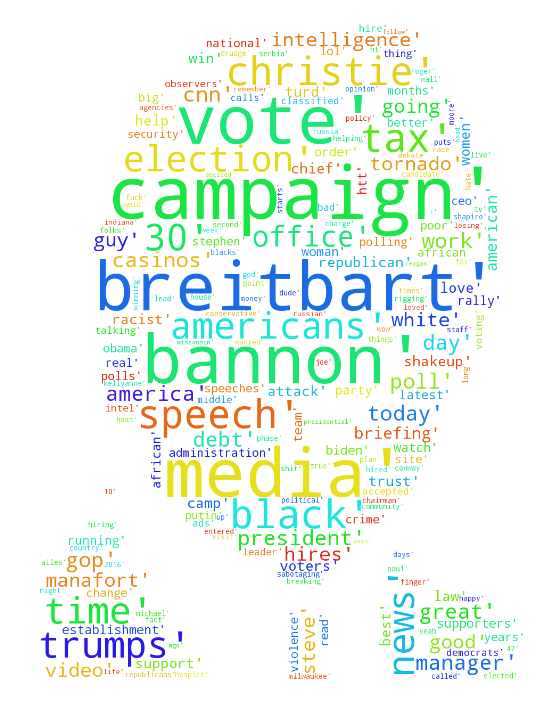

In [6]:
#Wordcloud using a mask.
from scipy.misc import imread
plt.rcParams['figure.figsize'] = (12, 12)

#twitter_mask = imread('img/twitter_mask.png', flatten=True)
twitter_mask = imread('./img/Trump.png', flatten=True)

wordcloud = WordCloud(
                      
                      stopwords=stopwords_new,
                      background_color='white',
                      width=1800,
                      height=1400,
                      mask=twitter_mask
            ).generate(wordcloudtext)

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./wordcloud/twitter_wordcloud_Trump_Mask.png', dpi=600)

plt.show()

### Search a specific term's most frequent occurrence with other terms

In [7]:
# Please change the file name in the variable below and point to the JSON file that you want to run.
# fname = './json/Trump_sample.json'
import operator 
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams 
import string
 
#fname = './json/Trump_sample.json'
#fname = './json/trump_TX.json'
fname = './json/trump_CA.json'
#fname = './json/hillary_CA.json'
#fname = './json/hillary_TX.json'

punctuation = list(string.punctuation)
word_list = open("./stopwords/stopwords.txt", "r")
additonalstopword =['rt', 'via', 'Did', 'Is', 'Well',  ':', '!', 'RT', 'The', 'I' ,'https','http', 'Who', 'amp', 'Not', 'For', 'A' , 'like', 'get', 'it\'s', 'don\'t', 'see', 'know', 'new' , 'say', 'i\'m', 'would', 'us', 'back', 'he\'s', 'back', 'want']
wordcloudtext=''

for line in word_list:
    additonalstopword.append(line.rstrip('\n'))
    additonalstopword.append(line.rstrip('\n') + '\'')
stop = stopwords.words('english') + punctuation + additonalstopword

with open(fname, 'r') as f:
    #search word
    search_word = 'muslim'
    count_search = Counter()
    for line in f:
        tweet = json.loads(line)
        # First create a list with all the terms
        try:
            terms_only = [term for term in preprocess(tweet['text']) if term not in stop and not term.startswith(('#', '@'))] 
        except KeyError:
            continue
        # Update the counter
        count_terms.update(terms_only)
        # then look for search word in the list of most frequent terms
        if search_word in terms_only:
                count_search.update(terms_only)
    print("\n\n")
    print("Co-occurrence for the searched word - %s:" % search_word)
    print("\n")
    print(count_search.most_common(20))
    print("\n")




Co-occurrence for the searched word - muslim:


[('muslim', 30), ('trump', 24), ('immigrants', 6), ('donald', 5), ('father', 4), ('american', 4), ('law', 4), ('sharia', 4), ('america', 4), ('sacrificed', 3), ('ban', 3), ('soldier', 3), ('anti', 3), ('https://t.co/srsfk0wdue', 3), ('death', 2), ('betsy', 2), ('internment', 2), ('telling', 2), ('vetting', 2), ('https://t.co/lnnlhrpcj1', 2)]




### The 20 most frequent terms occurring  together

In [8]:
# Please change the file name in the variable below and point to the JSON file that you want to run.
# fname = './json/Trump_sample.json'
#Build co-occurrence matrix : extending content of the term to the whole tweet.
#Term X and Y appears similar number of times in a tweet.

import operator 
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams 
import string
from collections import defaultdict
 
#python dict subclass that calls a factory function to supply missing values
com_dict = defaultdict(lambda : defaultdict(int))

#fname = './json/Trump_sample.json'
#fname = './json/trump_TX.json'
fname = './json/trump_CA.json'
#fname = './json/hillary_CA.json'
#fname = './json/hillary_TX.json'

punctuation = list(string.punctuation)
word_list = open("./stopwords/stopwords.txt", "r")
additonalstopword =['rt', 'via', 'Did', 'Is', 'Well',  ':', '!', 'RT', 'The', 'I' ,'https','http', 'Who', 'amp', 'Not', 'For', 'A' , 'like', 'get', 'it\'s', 'don\'t', 'see', 'know', 'new' , 'say', 'i\'m', 'would', 'us', 'back', 'he\'s', 'back', 'want']
wordcloudtext=''

for line in word_list:
    additonalstopword.append(line.rstrip('\n'))
    additonalstopword.append(line.rstrip('\n') + '\'')
stop = stopwords.words('english') + punctuation + additonalstopword


with open(fname, 'r') as f:   
    for line in f:
        tweet = json.loads(line)
        # Create a list with all the terms
        try:
            terms_only = [term for term in preprocess(tweet['text']) 
                      if term not in stop 
                      and not term.startswith(('#', '@'))]
        except KeyError:
            continue
        # Build co-occurrence matrix to hold the terms
        for i in range(len(terms_only)-1):            
            for j in range(i+1, len(terms_only)):
                words1, words2 = sorted([terms_only[i], terms_only[j]])                
                if words1 != words2:
                    com_dict[words1][words2] += 1                   
        co_ocurrence_matrix = []
# For each term, look for the most common co-occurrent terms
for term1 in com_dict:
    t1_max_terms = sorted(com_dict[term1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for term2, term2_count in t1_max_terms:
        co_ocurrence_matrix.append(((term1, term2), term2_count))
# Get the most frequent co-occurrences and sort
terms_max = sorted(co_ocurrence_matrix, key=operator.itemgetter(1), reverse=True)

print("\n\n")
print("The 20 most frequent terms occurring together: ")
print("\n")
print(terms_max[:20])
print("\n\n")





The 20 most frequent terms occurring together: 


[(('donald', 'trump'), 2567), (('campaign', 'trump'), 2246), (('hillary', 'trump'), 1042), (('clinton', 'trump'), 953), (('breitbart', 'trump'), 819), (('campaign', "trump's"), 715), (('trump', 'vote'), 666), (('christie', 'trump'), 661), (('tornado', 'turd'), 607), (('breitbart', 'campaign'), 601), (('media', 'trump'), 558), (('bannon', 'trump'), 529), (('tax', 'trump'), 497), (('campaign', 'manager'), 477), (('black', 'trump'), 477), (('president', 'trump'), 475), (('30', 'christie'), 458), (('christie', 'tax'), 457), (('30', 'trump'), 440), (('casinos', 'christie'), 438)]





## Trending III : Hashtags Time Series

In [9]:
# Please change the file name in the variable below and point to the JSON file that you want to run.
# fname = './json/stream_Trump_big.json'

#Also change the trending hashtags from results from cell above: Trending I : Topic Modelling (most frequent terms and hashtags)
#trending_hashtags_1 = '#trump'
#trending_hashtags_2 = '#hillarycoverageiscrap'
#trending_hashtags_3 = '#nevertrump'

#Also, add key name similar to hashtags without starting with '#' in the dictionary match_data
#See for an example, three hashtags: nevertrump, maga and job are used as key in the dictionary
#match_data = dict(nevertrump=per_minute_i, maga=per_minute_s, job=per_minute_e)
#Will make this dynamic in the future release.


import operator
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams
import string
import pandas
import vincent

#fname = './json/trump_TX.json'
fname = './json/trump_CA.json'
#fname = './json/hillary_CA.json'
#fname = './json/hillary_TX.json'

trending_hashtags_1 = '#nevertrump'
trending_hashtags_2 = '#maga'
trending_hashtags_3 = '#job'

punctuation = list(string.punctuation)
word_list = open("./stopwords/stopwords.txt", "r")
additonalstopword =['rt', 'via', 'Did', 'Is', 'Well',  ':', '!', 'RT', 'The', 'I' ,'https','http', 'Who', 'amp', 'Not', 'For', 'A' , 'like', 'get', 'it\'s', 'don\'t', 'see', 'know', 'new' , 'say', 'i\'m', 'would', 'us', 'back', 'he\'s', 'back', 'want']
wordcloudtext=''

for line in word_list:
    additonalstopword.append(line.rstrip('\n'))
    additonalstopword.append(line.rstrip('\n') + '\'')
stop = stopwords.words('english') + punctuation + additonalstopword


dates_hashtag1 = []
dates_hashtag2 = []
dates_hashtag3 = []


with open(fname, 'r') as f:
    count_hashtags = Counter()
    for line in f:
        tweet = json.loads(line)
        try:
            terms_hash = [term for term in preprocess(tweet['text']) if term.startswith('#')]
            if trending_hashtags_1 in terms_hash:
                dates_hashtag1.append(tweet['created_at'])
            elif trending_hashtags_2 in terms_hash:
                dates_hashtag2.append(tweet['created_at'])
            elif trending_hashtags_3 in terms_hash:
                dates_hashtag3.append(tweet['created_at'])
        except KeyError:
            continue


ones_hashtag1 = [1]*len(dates_hashtag1)
idx_hashtag1 = pandas.DatetimeIndex(dates_hashtag1)
trump = pandas.Series(ones_hashtag1, index=idx_hashtag1)
per_minute_i = trump.resample('1T').sum().fillna(0)

ones_hashtag2 = [1]*len(dates_hashtag2)
idx_hashtag2 = pandas.DatetimeIndex(dates_hashtag2)
maga = pandas.Series(ones_hashtag2, index=idx_hashtag2)
per_minute_s = maga.resample('1T').sum().fillna(0)


ones_hashtag3 = [1]*len(dates_hashtag3)
idx_hashtag3 = pandas.DatetimeIndex(dates_hashtag3)
job = pandas.Series(ones_hashtag3, index=idx_hashtag3)
per_minute_e = job.resample('1T').sum().fillna(0)


match_data = dict(nevertrump=per_minute_i, maga=per_minute_s, job=per_minute_e)

# Panda DataFrame to hold multiple series
all_matches = pandas.DataFrame(data=match_data,
                               index=per_minute_i.index)
# Resample for 1 min frequency

all_matches = all_matches.resample('1T').sum().fillna(0)


# Plot the time series using D3.js
time_chart = vincent.Line(all_matches[[trending_hashtags_1.replace('#', ''), trending_hashtags_2.replace('#', ''), trending_hashtags_3.replace('#', '')]])
time_chart.axis_titles(x='Time', y='Frequency')
time_chart.legend(title='Hashtags')
time_chart.to_json('./html/time_chart_all.json')

# Sentiment Analysis
### Electoral voters expressed in Tweet Sentiments

## Methodology:
1. Collect tweets mentioning Hillary Clinton and Donald Trump in two states: California and Texas.
2. Run IBM Alchemy API using the collected tweets and store calculated sentiment scores along with tweets to mongo db.
3. Extract JSON out of mongo DB and then generate GEO JSON files for positive and negative tweets.
4. Using leaflet.js and OpenStreetMap, dispay positive and negative tweets in California, Texas and surounding aeas for Hillary Clinton and Donald Trump.

   <BR>

<div class="image123">
    <div class="imgContainer">
        <img src="img/Electoral_Map.png" height="800" width="800"/>
    </div>
   
   
</div>

## IBM Alchemy API for twitter sentiment analysis

In [ ]:
#   
#  Copyright 2015 AlchemyAI
#   

##########################################################################################################
# This is a batch program as provided by IBM Alchemy API client.
# See Article for details: http://www.alchemyapi.com/developers/getting-started-guide/twitter-sentiment-analysis
# This client is customized to work as per the project requirement.
# Run this program from folder "alchemyapi-recipes-twitter" as
########### python alchemy_sentiment_analysis.py 'Trump_TX.json' 250
########### python alchemy_sentiment_analysis.py 'Trump_CA.json' 250
########### python alchemy_sentiment_analysis.py 'Hillary_TX.json' 250
########### python alchemy_sentiment_analysis.py 'Hillary_CA.json' 250
# First argument parameter is the JSON file stored in the JSON folder from the earlier run.
# Second argument parameter is number of tweets for sentiment analysis.
# IBM Alchemy API free account allows for free 1000 call each day . 
# This can be divided into four JSON files each with 250 calls to Alchemy API.


import os, sys, string, time, re
import requests, json, urllib, urllib2, base64
import pymongo
from multiprocessing import Pool, Lock, Queue, Manager

def main(search_term, num_tweets):

    # Establish credentials for Twitter and AlchemyAPI
    credentials = get_credentials()
    
    # Get the Twitter bearer token
    auth = oauth(credentials)

    # Pull Tweets down from the Twitter API
    raw_tweets = search(search_term, num_tweets, auth)
    #raw_tweets = search()

    # De-duplicate Tweets by ID
    unique_tweets = dedup(raw_tweets)

    # Enrich the body of the Tweets using AlchemyAPI
    search_target = search_term.rsplit('_', 1)[0]
    enriched_tweets = enrich(credentials, unique_tweets, sentiment_target = search_target)

    # Store data in MongoDB
    collection_name = search_term.rsplit('.json', 1)[0]
    collection_name ="sentiment_%s" % (collection_name)
    store(enriched_tweets, collection_name)

    # Print some interesting results to the screen
    print_results(collection_name)

    return

def get_credentials():
    creds = {}
    creds['consumer_key']    = str()
    creds['consumer_secret'] = str()
    creds['apikey']      = str()

    # If the file credentials.py exists, then grab values from it.
    # Values: "twitter_consumer_key," "twitter_consumer_secret," "alchemy_apikey"
    # Otherwise, the values are entered by the user
    try:
        import credentials
        creds['consumer_key']    = credentials.twitter_consumer_key
        creds['consumer_secret'] = credentials.twitter_consumer_secret
        creds['apikey']          = credentials.alchemy_apikey 
    except:
        print "No credentials.py found"
        creds['consumer_key']    = raw_input("Enter your Twitter API consumer key: ")
        creds['consumer_secret'] = raw_input("Enter your Twitter API consumer secret: ")
        creds['apikey']          = raw_input("Enter your AlchemyAPI key: ")
        
    print "Using the following credentials:"
    print "\tTwitter consumer key:", creds['consumer_key']
    print "\tTwitter consumer secret:", creds['consumer_secret']
    print "\tAlchemyAPI key:", creds['apikey']

    # Test the validity of the AlchemyAPI key
    test_url = "http://access.alchemyapi.com/calls/info/GetAPIKeyInfo"
    test_parameters = {"apikey" : creds['apikey'], "outputMode" : "json"}
    test_results = requests.get(url=test_url, params=test_parameters)
    test_response = test_results.json()

    if 'OK' != test_response['status']:
        print "Oops! Invalid AlchemyAPI key (%s)" % creds['apikey']
        print "HTTP Status:", test_results.status_code, test_results.reason
        sys.exit()

    return creds

def oauth(credentials):

    print "Requesting bearer token from Twitter API"

    try:
        # Encode credentials
        encoded_credentials = base64.b64encode(credentials['consumer_key'] + ':' + credentials['consumer_secret'])        
        # Prepare URL and HTTP parameters
        post_url = "https://api.twitter.com/oauth2/token"
        parameters = {'grant_type' : 'client_credentials'}
        # Prepare headers
        auth_headers = {
            "Authorization" : "Basic %s" % encoded_credentials,
            "Content-Type"  : "application/x-www-form-urlencoded;charset=UTF-8"
            }

        # Make a POST call
        results = requests.post(url=post_url, data=urllib.urlencode(parameters), headers=auth_headers)
        response = results.json()

        # Store the access_token and token_type for further use
        auth = {}
        auth['access_token'] = response['access_token']
        auth['token_type']   = response['token_type']

        print "Bearer token received"
        return auth

    except Exception as e:
        print "Failed to authenticate with Twitter credentials:", e
        print "Twitter consumer key:", credentials['consumer_key']
        print "Twitter consumer secret:", credentials['consumer_secret']
        sys.exit()
        

def search(search_term, num_tweets, auth):
    # This collection will hold the Tweets as they are returned from Twitter
    data_dir ='json'
    fname= "../%s/%s" % (data_dir, search_term)
    collection = []
    #num_tweets =1000
    with open(fname, 'r') as f:
        for line in f:
            status = json.loads(line)
            try:
                #print status
                text = status['text'].encode('utf-8')
                #print text
            
                # Filter out retweets
                if status['retweeted'] == True:
                    continue
                if text[:3] == 'RT ':
                    continue
        
        
                tweet = {}
                if status['geo']:
                    # Configure the fields you are interested in from the status object
                    tweet['text']        = text
                    tweet['id']          = status['id']
                    tweet['time']        = status['created_at'].encode('utf-8')
                    tweet['screen_name'] = status['user']['screen_name'].encode('utf-8')
                    tweet['lat'] = status['geo']['coordinates'][0]
                    tweet['lon'] = status['geo']['coordinates'][1]
                
                
                    collection    += [tweet]
                if len(collection) >= num_tweets:
                    print "Search complete! Found %d tweets" % len(collection)
                    return collection
            #print tweet['id']
            except KeyError:
                continue
    
    
#collection = []
#    collection = [line.strip() for line in open("/Users/Home/src/recipes/alchemyapi-recipes-twitter/data10.txt", 'r')]
#    return collection



def enrich(credentials, tweets, sentiment_target = ''):
    # Prepare to make multiple asynchronous calls to AlchemyAPI
    apikey = credentials['apikey']
    pool = Pool(processes = 10)
    mgr = Manager()
    result_queue = mgr.Queue()
    # Send each Tweet to the get_text_sentiment function
    for tweet in tweets:
        pool.apply_async(get_text_sentiment, (apikey, tweet, sentiment_target, result_queue))

    pool.close()
    pool.join()
    collection = []
    while not result_queue.empty():
        collection += [result_queue.get()]
    
    print "Enrichment complete! Enriched %d Tweets" % len(collection)
    return collection

def get_text_sentiment(apikey, tweet, target, output):

    # Base AlchemyAPI URL for targeted sentiment call
    alchemy_url = "http://access.alchemyapi.com/calls/text/TextGetTextSentiment"
    
    # Parameter list, containing the data to be enriched
    parameters = {
        "apikey" : apikey,
        "text"   : tweet['text'],
        "outputMode" : "json",
        "showSourceText" : 1
        }

    try:

        results = requests.get(url=alchemy_url, params=urllib.urlencode(parameters))
        response = results.json()

    except Exception as e:
        print "Error while calling TextGetTargetedSentiment on Tweet (ID %s)" % tweet['id']
        print "Error:", e
        return

    try:
        if 'OK' != response['status'] or 'docSentiment' not in response:
            print "Problem finding 'docSentiment' in HTTP response from AlchemyAPI"
            print response
            print "HTTP Status:", results.status_code, results.reason
            print "--"
            return

        tweet['sentiment'] = response['docSentiment']['type']
        tweet['score'] = 0.
        if tweet['sentiment'] in ('positive', 'negative'):
            tweet['score'] = float(response['docSentiment']['score'])
        output.put(tweet)

    except Exception as e:
        print "D'oh! There was an error enriching Tweet (ID %s)" % tweet['id']
        print "Error:", e
        print "Request:", results.url
        print "Response:", response

    return

def dedup(tweets):
    used_ids = []
    collection = []
    for tweet in tweets:
        if tweet['id'] not in used_ids:
            used_ids += [tweet['id']]
            collection += [tweet]
    print "After de-duplication, %d tweets" % len(collection)
    return collection

def store(tweets, collection_name):
    # Instantiate your MongoDB client
    mongo_client = pymongo.MongoClient()
    # Retrieve (or create, if it doesn't exist) the twitter_db database from Mongo
    db = mongo_client.twitter_db
    
    if collection_name in db.collection_names():
        if ( db[collection_name].count() != 0 ) :
            #print 'collection already exists'
            db[collection_name].delete_many({})
    
   
    db_tweets = db[collection_name]

    for tweet in tweets:
        db_id = db_tweets.insert(tweet)

    db_count = db_tweets.count()
    #filename ="../json/sentiment_%s.json" % (collection_name)
    filename ="../json/%s.json" % (collection_name)

    with open(filename, 'w') as outfile:
        for tweet in tweets:
            outfile.write(str(tweet))
    outfile.close()


    print("Tweets stored in MongoDB! collection: %s. Number of documents in twitter_db: %d" % (collection_name, db_count))
    print("Tweets stored in JSON file: %s. " % (filename))

    return

def print_results(collection_name):

    print ''
    print ''
    print '###############'
    print '#    Stats    #'
    print '###############'
    print ''
    print ''    
    
    db = pymongo.MongoClient().twitter_db
    tweets = db[collection_name]

    num_positive_tweets = tweets.find({"sentiment" : "positive"}).count()
    num_negative_tweets = tweets.find({"sentiment" : "negative"}).count()
    num_neutral_tweets = tweets.find({"sentiment" : "neutral"}).count()
    num_tweets = tweets.find().count()
    #print num_positive_tweets
    #print num_negative_tweets
    #print num_neutral_tweets
    #print num_tweets

    if num_tweets != sum((num_positive_tweets, num_negative_tweets, num_neutral_tweets)):
        print "Counting problem!"
        print "Number of tweets (%d) doesn't add up (%d, %d, %d)" % (num_tweets, 
                                                                     num_positive_tweets, 
                                                                     num_negative_tweets, 
                                                                     num_neutral_tweets)
        sys.exit()

    most_positive_tweet = tweets.find_one({"sentiment" : "positive"}, sort=[("score", -1)])
    most_negative_tweet = tweets.find_one({"sentiment" : "negative"}, sort=[("score", 1)])

    print "SENTIMENT BREAKDOWN"
    print "Number (%%) of positive tweets: %d (%.2f%%)" % (num_positive_tweets, 100*float(num_positive_tweets) / num_tweets)
    print "Number (%%) of negative tweets: %d (%.2f%%)" % (num_negative_tweets, 100*float(num_negative_tweets) / num_tweets)
    print "Number (%%) of neutral tweets: %d (%.2f%%)" % (num_neutral_tweets, 100*float(num_neutral_tweets) / num_tweets)
    print ""
        
    print "MOST POSITIVE TWEET"
    print "Text: %s" % most_positive_tweet['text']
    print "User: %s" % most_positive_tweet['screen_name']
    print "Time: %s" % most_positive_tweet['time']
    print "Score: %f" % float(most_positive_tweet['score'])
    print ""
    
    print "MOST NEGATIVE TWEET"
    print "Text: %s" % most_negative_tweet['text']
    print "User: %s" % most_negative_tweet['screen_name']
    print "Time: %s" % most_negative_tweet['time']
    print "Score: %f" % float(most_negative_tweet['score'])
    return




    try:
        mean_results = list(tweets.aggregate([{"$group" : {"_id": "$sentiment", "avgScore" : { "$avg" : "$score"}}}]))
        avg_pos_score = mean_results[0]['avgScore']
        print "AVERAGE POSITIVE TWEET SCORE: %f" % float(avg_pos_score)
        if len(mean_results) >1:
            avg_neg_score = mean_results[1]['avgScore']
            print "AVERAGE NEGATIVE TWEET SCORE: %f" % float(avg_neg_score)

    except IndexError:
        print 'no avg score'

    return

if __name__ == "__main__":

    if not len(sys.argv) == 3:
        print "ERROR: invalid number of command line arguments"
        print "SYNTAX: python recipe.py <JSON_FILE_NAME> <NUM_TWEETS>"
        print "\t<JSON_FILE_NAME> : the JSON file to be used for Sentiment Analysis such as trump_TX.json"
        print "\t<NUM_TWEETS>  : the preferred number of Tweets to pull from Twitter's API"
        sys.exit()

    else:
        main(sys.argv[1], int(sys.argv[2]))




### Visualize Twitter Sentiment Score

IBM Alchemy API provides some sample code to visualize twitter sentiment score.<br>
For details, see URL: http://www.alchemyapi.com/developers/getting-started-guide/twitter-sentiment-analysis <br>
To generate graph as shown below:
1. Run write.py (in the folder alchemyapi-recipes-twitter) on a terminal <br>
python write.py
2. Run R Script plot.R on a machine with R installed. Will need all the files stored in the  folder alchemyapi-recipes-twitter <br>
R < plot.R --vanilla


 <center><h3>Twitter Sentiment Score for Trump in Texas </h3></center>
 <BR>

<div class="image123">
    <div class="imgContainer">
        <img src="./alchemyapi-recipes-twitter/twitter_sentiment_raw.png" height="600" width="800"/>
    </div>
   
</div>


### Check Mongo Db for the Sentiment score collections created by Alchemy API
#### Note: Name of sentiment score collections created by Alchemy API starts with prefix "sentiment_"

In [10]:
# Tweets with Sentiment type and score attached as stored in the Mongo DB
import pymongo
mongo_client = pymongo.MongoClient()
db = mongo_client.twitter_db
for collection in db.collection_names():
    print("Collection name: %s and number of tweets stored: %s  " % (collection, db[collection].count()))

#collection_name= 'sentiment_trump_TX'
# To see the output of IBM Alchemy API, uncomment following three lines
#cursor = db.stream_Trump_big.find()
#for document in cursor:
#    print(document)

# To To delete all the recordes from a collection
#if collection_name in db.collection_names():
#    if ( db[collection_name].count() != 0 ) :
#        print 'collection already exists'
#        db[collection_name].delete_many({})
#        print db[collection_name].count()
        

# To drop all the collections from Mongo DB.
#for collection in db.collection_names():
#    db.drop_collection(collection)

Collection name: sentiment_trump_TX and number of tweets stored: 10  
Collection name: hillary_TX and number of tweets stored: 2095  
Collection name: sentiment_trump_CA and number of tweets stored: 241  
Collection name: hillary_CA and number of tweets stored: 1990  
Collection name: trump_TX and number of tweets stored: 9  
Collection name: trump_CA and number of tweets stored: 26209  


### Generate Geo JSON files for positive and negative sentiments

In [11]:
#Run this following code for the four JSON files created in the above steps.
#This means this cell has to be run four times, each with different input JSON and output GEO JSON files.

#change the JSON file name in the variable fname. See commented variables below. 
#Uncomment one variable and run the cell (remember to change the output GEO jso file names as well.)


#For example, to run for Trump in Texas uncomment following lines:

#fname = './map/sentiment_trump_CA.json'
#output_geo_json_positive = './map/geo_data_trump_texas_positive_new.json'
#output_geo_json_negative = './map/geo_data_trump_texas_negative_new.json'


import json
import ast

fname = './map/sentiment_trump_CA.json'
#fname = './map/sentiment_trump_TX.json'
#fname = './map/sentiment_hillary_CA.json'
#fname = './map/sentiment_hillary_TX.json'

#output_geo_json_positive = './map/geo_data_trump_texas_positive_new.json'
#output_geo_json_negative = './map/geo_data_trump_texas_negative_new.json'

output_geo_json_positive = './map/geo_data_trump_california_positive_new.json'
output_geo_json_negative = './map/geo_data_trump_california_negative_new.json'
#output_geo_json_positive = './map/geo_data_hillary_texas_positive_new.json'
#output_geo_json_negative = './map/geo_data_hillary_texas_negative_new.json'
#output_geo_json_positive = './map/geo_data_hillary_california_positive_new.json'
#output_geo_json_negative = './map/geo_data_hillary_california_negative_new.json'

with open(fname, 'r') as f:
    geo_data_positive = {
        "type": "FeatureCollection",
        "features": []
    }
    geo_data_negative = {
        "type": "FeatureCollection",
        "features": []
    }
    for line in f:
        tweet = json.loads(line)
        try:
            if tweet['sentiment'] == "positive":
                coordinates = '''{"type":"Point","coordinates": [''' + str(tweet['lon'] ) + ',' + str(tweet['lat']) + ']}'
                #print coordinates
                geo_json_feature_positive = {
                    "type": "Feature",
                    "geometry": ast.literal_eval(coordinates),
                    
                    "properties": {
                        "text": tweet['text'],
                        "created_at": tweet['time']
                    }
                }
                #print geo_json_feature
                geo_data_positive['features'].append(geo_json_feature_positive)
            elif tweet['sentiment'] == "negative":
                coordinates = '''{"type":"Point","coordinates": [''' + str(tweet['lon'] ) + ',' + str(tweet['lat']) + ']}'
                #print coordinates
                geo_json_feature_negative = {
                    "type": "Feature",
                    "geometry": ast.literal_eval(coordinates),
                    
                    "properties": {
                        "text": tweet['text'],
                        "created_at": tweet['time']
                    }
                }
                #print geo_json_feature
                geo_data_negative['features'].append(geo_json_feature_negative)



        except:
            continue
 


#Save geo data
with open(output_geo_json_positive, 'w') as foutpositive:
    foutpositive.write(json.dumps(geo_data_positive, indent=4))
with open(output_geo_json_negative, 'w') as foutnegative:
    foutnegative.write(json.dumps(geo_data_negative, indent=4))


## Twitter Sentiment Map



<div class="image123">
    <div class="imgContainer">
        <img src="./img/TwitterSentimentMap.png" height="600" width="800"/>
    </div>
   
</div>






<div class="image123">
    <div class="imgContainer">
        <img src="./img/Sentiment Results.png" height="600" width="800"/>
    </div>
   
</div>